In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax

In [3]:
train = pd.read_csv('data_vova/hugface_sentiment_sent_sim_embs_train.csv')
test = pd.read_csv('data_vova/hugface_sentiment_sent_sim_embs_test.csv')

public_class_balence = [0.  , 0.1 , 0.45, 0.4 , 0.05]

# wery clouse to train samples

In [50]:
close_to_train = test[['emb_sim_1','emb_sim_2', 'emb_sim_3', 'emb_sim_4', 'emb_sim_5']]> 0.8
close_to_train = close_to_train[close_to_train.any(axis=1)].idxmax(axis=1)
close_to_train = close_to_train.apply(lambda x: int(x[-1])).to_dict()
close_to_train

{0: 2, 1: 3, 2: 4, 18: 5, 24: 1}

# Prediction based on similaryty

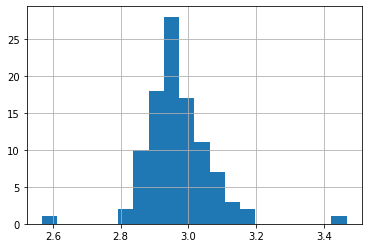

In [51]:
softmax_prob = test[['emb_sim_1','emb_sim_2', 'emb_sim_3', 'emb_sim_4', 'emb_sim_5']].apply(softmax, axis=1)
text_similarity_prediction = (softmax_prob*np.array([1,2,3,4,5])).sum(axis=1)
text_similarity_prediction.hist(bins=20);

# Prediction based on sentiment analysis

In [52]:
from scipy.stats import rankdata

public_class_n_sample = [(int(sum(public_class_balence[:i]*100)), int(sum(public_class_balence[:i+1]*100)))  for i in range(len(public_class_balence))]

def to_public_class_balance(ranks):
    balence_pred = ranks.sort_values()
    for i, (left, right) in enumerate(public_class_n_sample):
        balence_pred[left:right]= i+1
    balence_pred = balence_pred.sort_index()
    return balence_pred

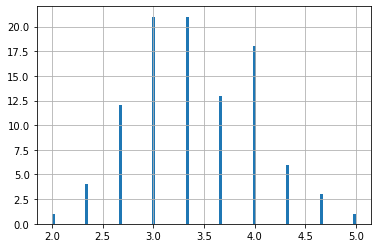

In [55]:
berts = ['trans_baselinepos_prob', 'rohanrajpal_bert_base_multilingual_codemixed-cased_sentimentpos_prob', 'siebert_sentiment_roberta_large_englishpos_prob']
berts_weights = np.array([2, 1, 1]) 
bert_data = test[berts].apply(rankdata)
bert_data = bert_data*berts_weights
bert_data = bert_data.apply(to_public_class_balance)
sentiment_pred = bert_data.mean(axis=1)
sentiment_pred.hist(bins=100);

#  Blend

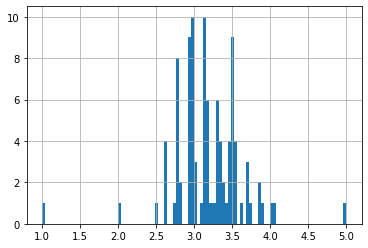

In [57]:
pred = sentiment_pred*0.5 + text_similarity_prediction*0.5
pred[close_to_train.keys()] = list(close_to_train.values())
pred.hist(bins=100);

In [61]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['sentiment'] = pred
sample_submission.to_csv('sub_final_blend.csv', index=False)#sub_rank_class_balence_34_base_rohanrajpal_siebert
sample_submission

,id,sentiment
0,0,2.000000
1,1,3.000000
2,2,4.000000
3,3,3.189163
4,4,3.184166
...,...,...
95,95,3.368291
96,96,3.313244
97,97,3.321575
98,98,2.992070
